This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_bistable2
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 10.0
num_steps = 1000
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

a1_mean = 0.9
a2_mean = 1.1

test1 = Test(model=model_bistable2({'a': ('norm', (a1_mean, 0.2))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_bistable2({'a': ('norm', (a2_mean, 0.2))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

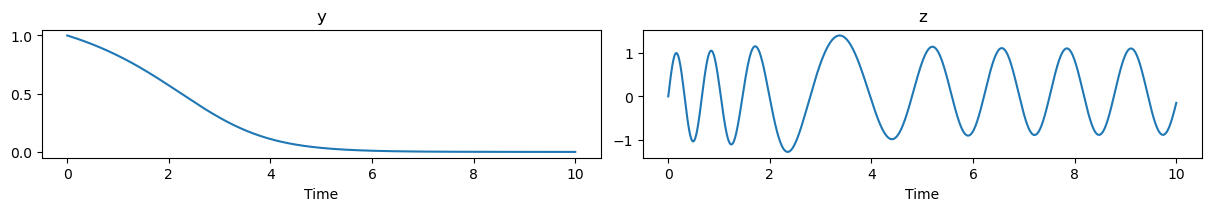

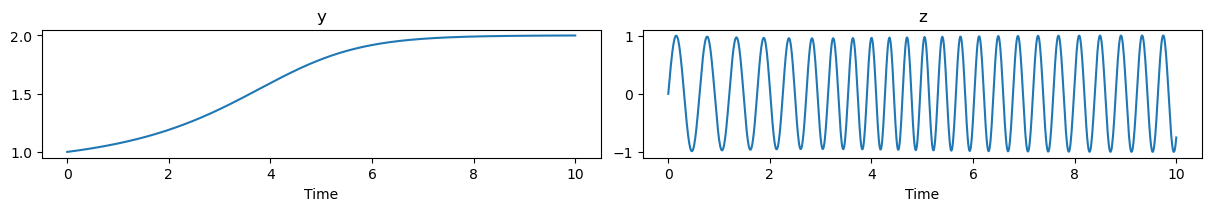

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

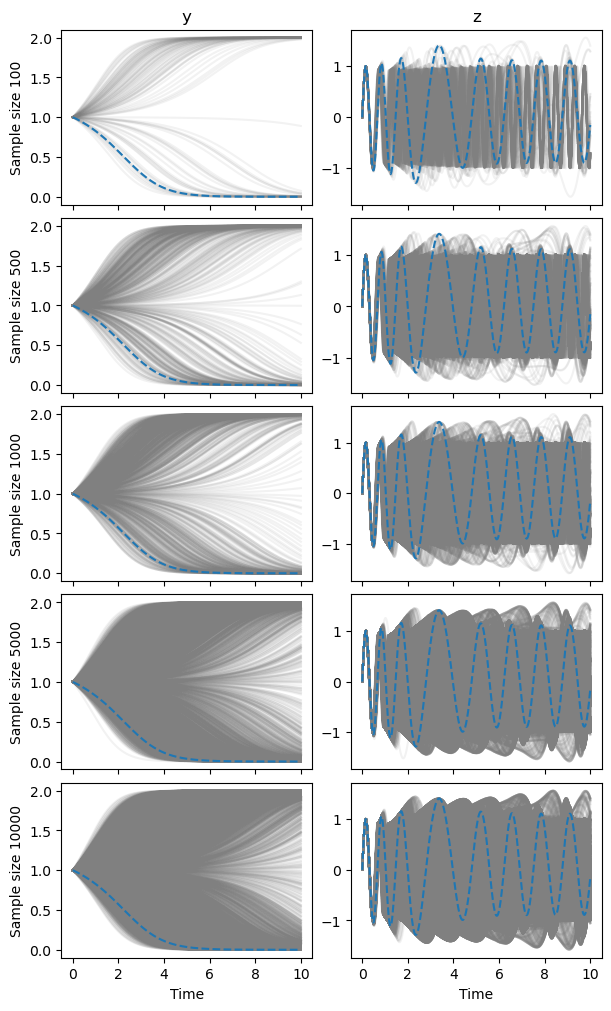

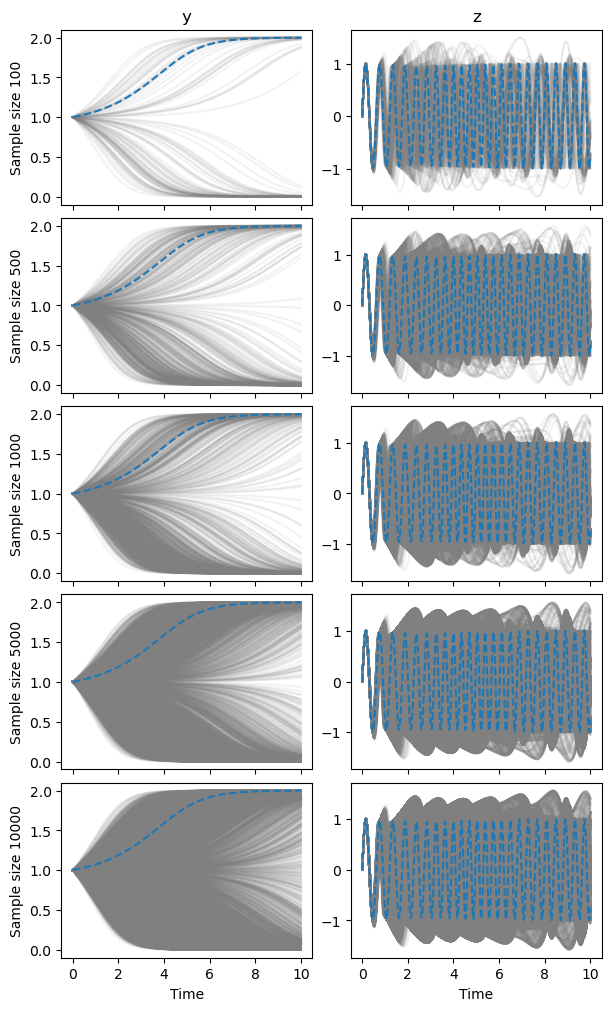

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

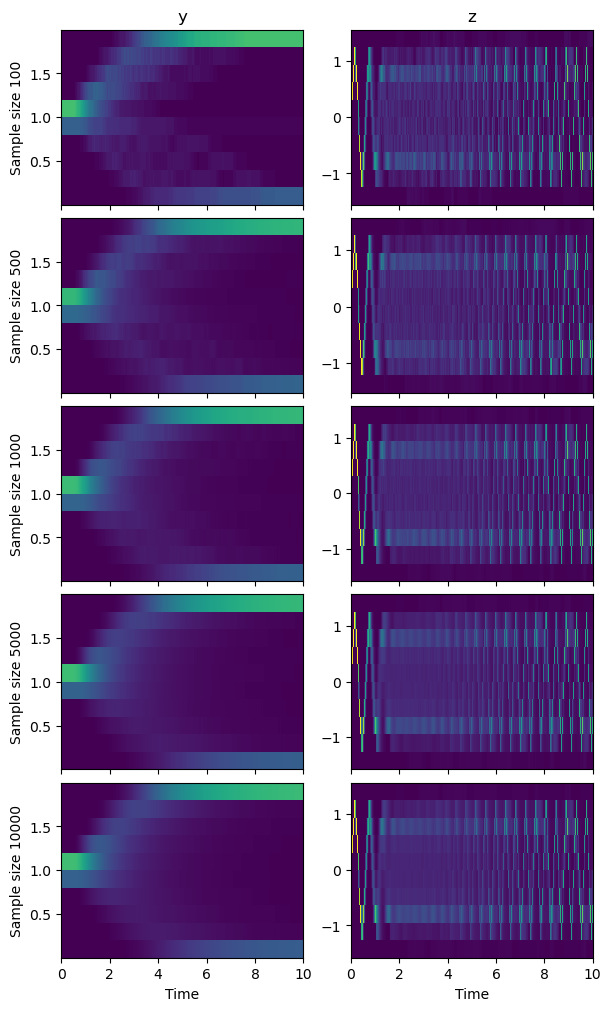

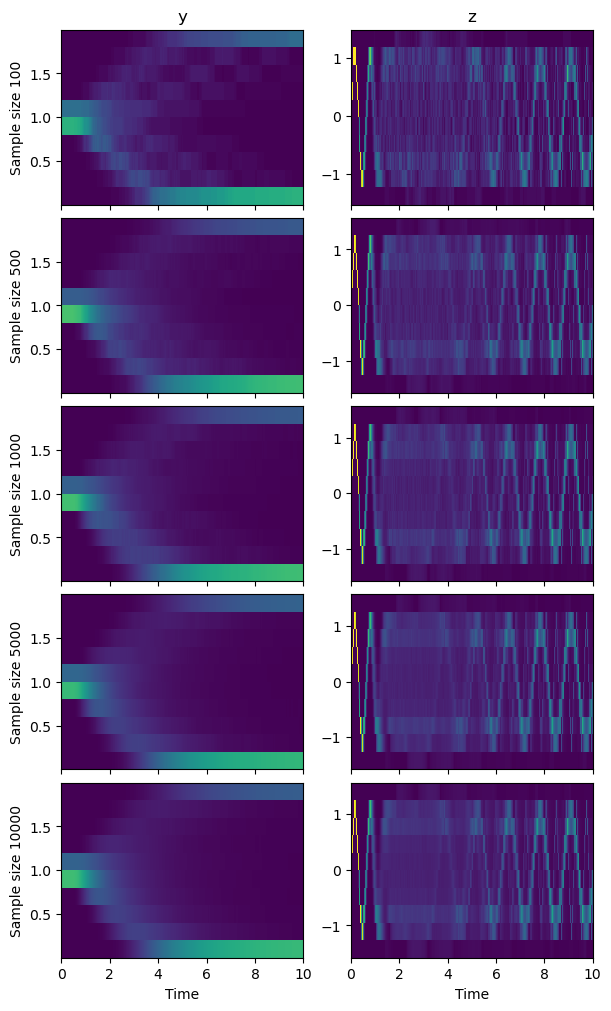

In [5]:
for test in tests:
    _ = test.plot_distributions()

C:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


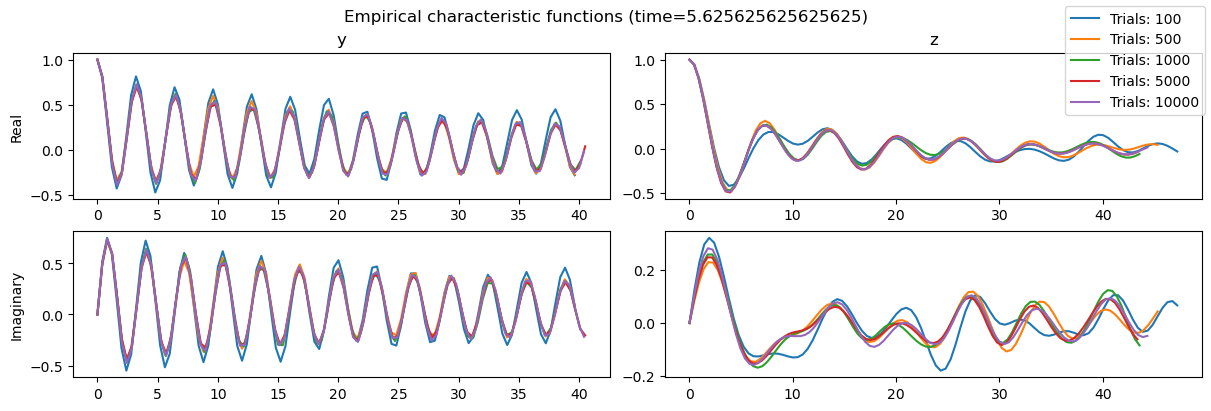

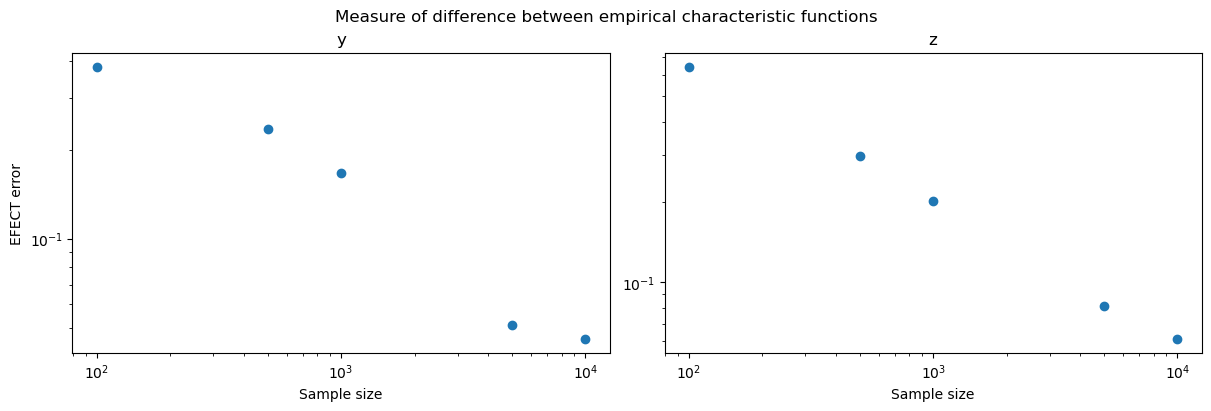

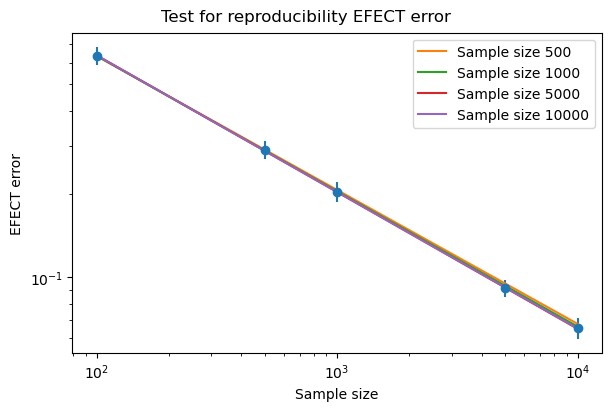

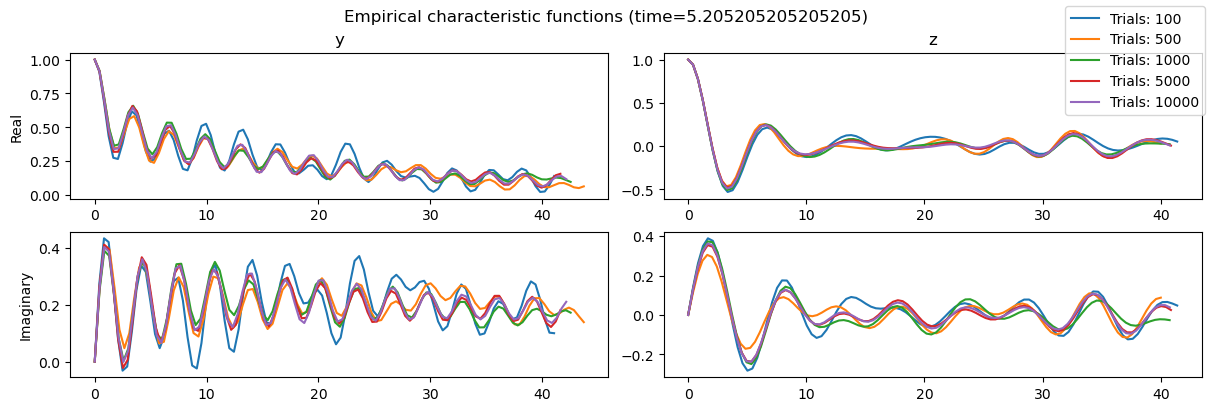

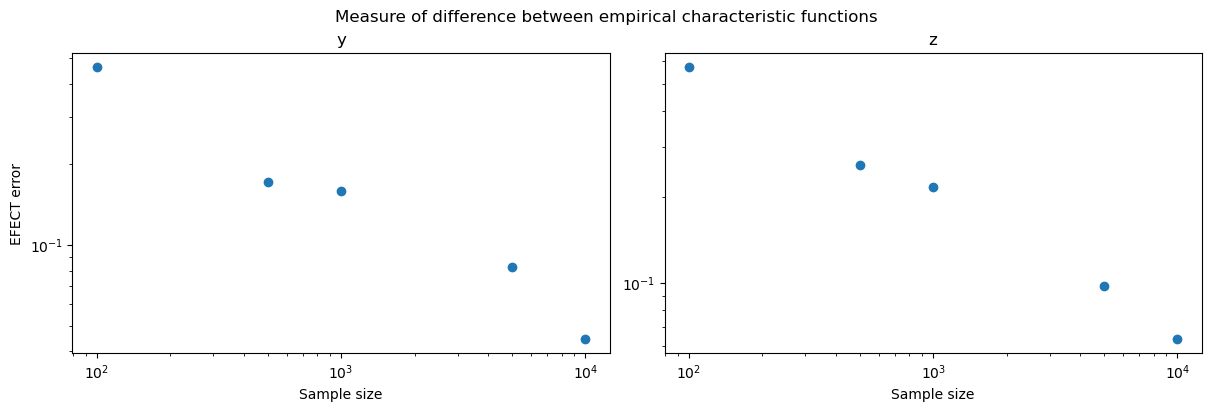

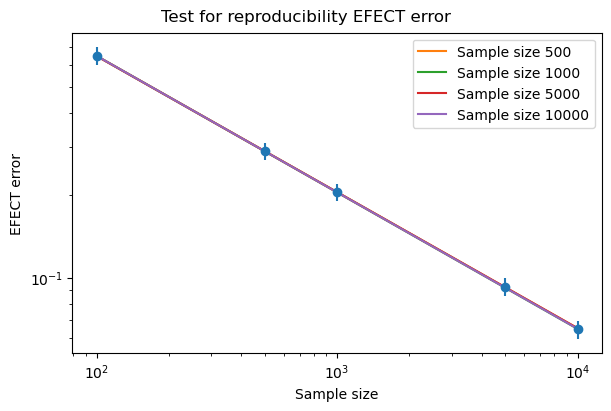

In [6]:
# Runtime: ~159 minutes (M1 max)
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

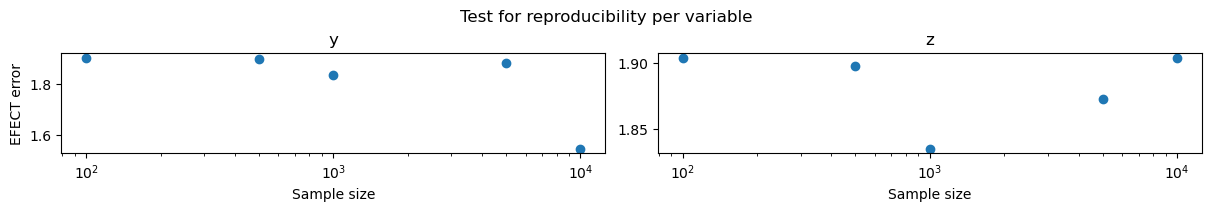

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('Sample size')
    ax[i].set_xscale('log')
    ax[i].set_title(name)
ax[0].set_ylabel('EFECT error')
_ = fig.suptitle('Test for reproducibility per variable')

Testing for how well the method can detect differences in model parameters. 

Output()

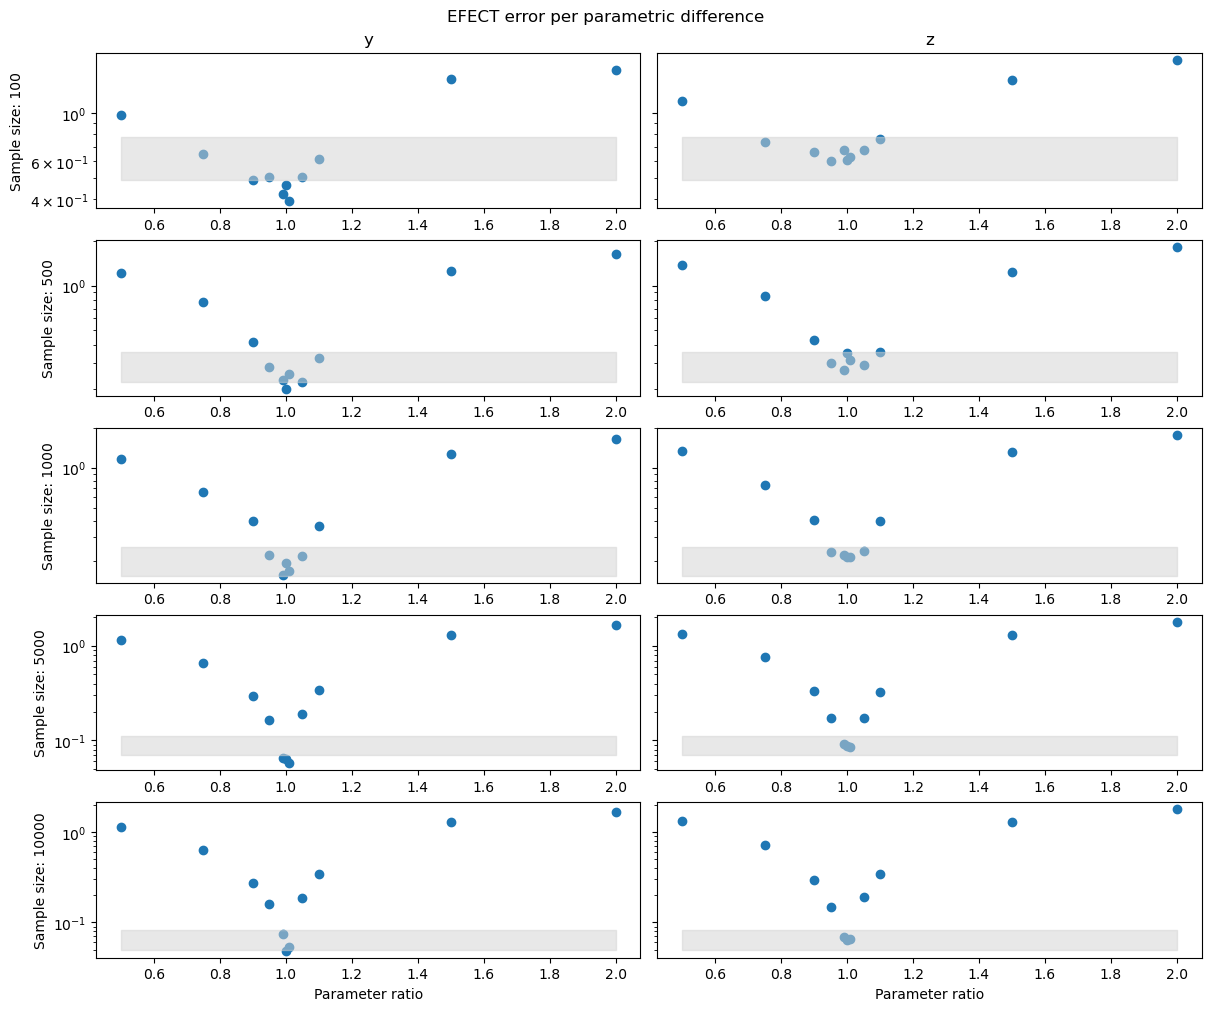

In [8]:
a_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
a_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for af in a_fact:
    label.value = f'Factor: {af}...'

    atest_mean = a1_mean * af
    test = Test(model=model_bistable2({'a': ('norm', (atest_mean, 0.2))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    a_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(a_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in a_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(a_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('EFECT error per parametric difference')

In [9]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'EFECT error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in a_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(a_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.633593,0.048159
500,0.28994,0.021812
1000,0.203822,0.016625
5000,0.091145,0.006728
10000,0.065325,0.005462


Sample size  \
Sample size Scaling factor EFECT error Standardized error Acceptance p-value                
100         0.50           1.132789     10.365560         0.019608                    100   
            0.75           0.733971     2.084301          0.235294                    100   
            0.90           0.659807     0.544323          1.000000                    100   
            0.95           0.598773    -0.723006          1.000000                    100   
            0.99           0.672424     0.806306          1.000000                    100   
            1.00           0.606064    -0.571614          1.000000                    100   
            1.01           0.628905    -0.097345          1.000000                    100   
            1.05           0.677506     0.911844          1.000000                    100   
            1.10           0.755817     2.537924          0.156863                    100   
            1.50           1.433451     16.608646         0.019608                    100   
            2.00           1.760412     23.397820         0.019608                    100   
500         0.50           1.376534     49.816509         0.003984                    500   
            0.75           0.845533     25.472005         0.003984                    500   
            0.90           0.427825     6.321556          0.027888                    500   
            0.95           0.302045     0.554966          1.000000                    500   
            0.99           0.267798    -1.015110          1.000000                    500   
            1.00           0.349547     2.732780          0.135458                    500   
            1.01           0.315949     1.192419          0.705179                    500   
            1.05           0.291788     0.084725          1.000000                    500   
            1.10           0.358507     3.143581          0.103586                    500   
            1.50           1.253649     44.182666         0.003984                    500   
            2.00           1.810119     69.694868         0.003984                    500   
1000        0.50           1.349944     68.940308         0.001996                   1000   
            0.75           0.740981     32.310625         0.001996                   1000   
            0.90           0.403455     12.008145         0.007984                   1000   
            0.95           0.231716     1.677886          0.357285                   1000   
            0.99           0.220766     1.019235          0.966068                   1000   
            1.00           0.212483     0.520980          1.000000                   1000   
            1.01           0.214385     0.635382          1.000000                   1000   
            1.05           0.237588     2.031086          0.243513                   1000   
            1.10           0.400689     11.841737         0.007984                   1000   
            1.50           1.313062     66.721826         0.001996                   1000   
            2.00           1.772468     94.355553         0.001996                   1000   
5000        0.50           1.320780     182.772565        0.000400                   5000   
            0.75           0.754639     98.621450         0.000400                   5000   
            0.90           0.330191     35.531663         0.000800                   5000   
            0.95           0.172337     12.068320         0.007197                   5000   
            0.99           0.092350     0.179101          1.000000                   5000   
            1.00           0.087333    -0.566566          1.000000                   5000   
            1.01           0.084978    -0.916685          1.000000                   5000   
            1.05           0.188692     14.499364         0.004798                   5000   
            1.10           0.343909     37.570719         0.000800             